# Introduction

The 10 tracks grouped by cluster I produced are not UMI aware. I need to filter the tracks down to only include one instance of a UMI.

In [1]:
ls

align-star.condor                   build_cluster_4.sh*
align-star.condor~                  build_cluster_4.sh~
barcodes-10x-cluster-0-run-12.txt   build_cluster_7.condor
barcodes-10x-cluster-0-run-13.txt   build_cluster_7.condor~
barcodes-10x-cluster-0-run-1.txt    build_cluster_7.sh*
barcodes-10x-cluster-0-run-3.txt    build_cluster_7.sh~
barcodes-10x-cluster-0-run-4.txt    build_cluster_filtered_bams.condor
barcodes-10x-cluster-0-run-5.txt    build_cluster_filtered_bams.condor~
barcodes-10x-cluster-0-run-6.txt    build-umi-filtered-tracks.ipynb
barcodes-10x-cluster-0-run-7.txt    c0_mesprox/
barcodes-10x-cluster-0-run-8.txt    c0_mesprox_trans/
barcodes-10x-cluster-12-run-12.txt  c12_mus4/
barcodes-10x-cluster-12-run-13.txt  c12_mus4_trans/
barcodes-10x-cluster-12-run-1.txt   c17_mus3/
barcodes-10x-cluster-12-run-4.txt   c17_mus3_trans/
barcodes-10x-cluster-12-run-5.txt   c2_mesdist/
barcodes-10x-cluster-12-run-6.txt   c4_mus2/
barcodes-10x-cluster-12-run-8.txt   c4_mus2_trans/
barc

In [9]:
import pandas
import numpy
import pysam
import os
import re
from collections import Counter
from glob import glob
from matplotlib import pyplot

In [3]:
tenx_root = '/woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/'

tenx_bam = {
    1: os.path.join(tenx_root, 'Wold10x-1-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    3: os.path.join(tenx_root, 'Wold10x-3-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    4: os.path.join(tenx_root, 'Wold10x-4-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    5: os.path.join(tenx_root, 'Wold10x-5-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    6: os.path.join(tenx_root, 'Wold10x-6-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    7: os.path.join(tenx_root, 'Wold10x-7-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    8: os.path.join(tenx_root, 'Wold10x-8-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    9: os.path.join(tenx_root, 'Wold10x-9-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    10: os.path.join(tenx_root, 'Wold10x-10-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    11: os.path.join(tenx_root, 'Wold10x-11-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    12: os.path.join(tenx_root, 'Wold10x-12-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
    13: os.path.join(tenx_root, 'Wold10x-13-encode-count-cells10000', 'outs', 'possorted_genome_bam.bam'),
}

for cluster in tenx_bam:
    if not os.path.exists(tenx_bam[cluster]):
        print('missing {}'.format(tenx_bam[cluster]))

In [4]:
def get_cluster_barcodes(cluster):
    results = []
    run_re = re.compile('barcodes-10x-cluster-{cluster}-run-(?P<run>[\d]+)\.txt'.format(cluster=cluster))
    pattern = 'barcodes-10x-cluster-{cluster}-run-*.txt'.format(cluster=cluster)
    for filename in glob(pattern):
        match = run_re.match(filename)
        run = int(match.group('run'))
        results.append((run, filename))
    return sorted(results)
        
get_cluster_barcodes(12)

[(1, 'barcodes-10x-cluster-12-run-1.txt'),
 (4, 'barcodes-10x-cluster-12-run-4.txt'),
 (5, 'barcodes-10x-cluster-12-run-5.txt'),
 (6, 'barcodes-10x-cluster-12-run-6.txt'),
 (8, 'barcodes-10x-cluster-12-run-8.txt'),
 (12, 'barcodes-10x-cluster-12-run-12.txt'),
 (13, 'barcodes-10x-cluster-12-run-13.txt')]

In [5]:
def build_barcode_re(barcode_filename):
    barcodes = []
    with open(barcode_filename, 'rt') as instream:
        for line in instream:
            barcode = line.rstrip().split(':')[2]
            barcodes.append('(' + barcode + ')')
    return re.compile('|'.join(barcodes))

barcode_re = build_barcode_re('barcodes-10x-cluster-12-run-1.txt')

In [ ]:
umis = {}
possorted_bam = pysam.AlignmentFile(tenx_bam[1], 'rb')
for i, read in enumerate(possorted_bam):
    if not read.is_unmapped:
        nh = read.get_tag('NH')
        if nh == 1 and read.has_tag('CB'):
            assert read.mapq == 255
            cb = read.get_tag('CB')
            if barcode_re.match(cb) and read.has_tag('UB'):
                ub = read.get_tag('UB')
                location = (read.reference_name, read.reference_start, read.reference_end)
                umis.setdefault((cb,ub), Counter())[location] += 1


In [8]:
len(umis)

2004374

In [12]:
list(umis)[:5]

[('CGCCAAGAGACGCACA-1', 'ATGGACACAG'),
 ('ATCTACTCAATGTTGC-1', 'CGAATGGAGA'),
 ('ATGTGTGAGATATGGT-1', 'CACACGGAGG'),
 ('TAGTTGGCAGCTGTGC-1', 'TTTGGCCTAG'),
 ('TGCCAAAAGCGCTTAT-1', 'CTCAGTCCAG')]

In [18]:
[umis[('CGCCAAGAGACGCACA-1', 'ATGGACACAG')][x] for x in umis[('CGCCAAGAGACGCACA-1', 'ATGGACACAG')]]

[1, 1]

In [29]:
xs = []
ys = []
for i, u in enumerate(umis):
    xs.append(len(umis[u]))
    ys.append(sum([umis[u][x] for x in umis[u]]))


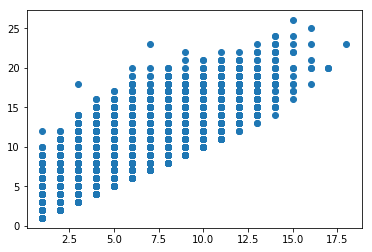

In [30]:
pyplot.scatter(xs, ys)

In [32]:
umi_decrease = []
for x,y in zip(xs, ys):
    umi_decrease.append(y-x)

(array([1.162183e+06, 4.909140e+05, 2.081950e+05, 8.601300e+04,
        0.000000e+00, 3.474500e+04, 1.362400e+04, 5.460000e+03,
        2.033000e+03, 0.000000e+00, 7.850000e+02, 2.580000e+02,
        9.900000e+01, 4.200000e+01, 0.000000e+00, 1.600000e+01,
        4.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. ]),
 <a list of 20 Patch objects>)

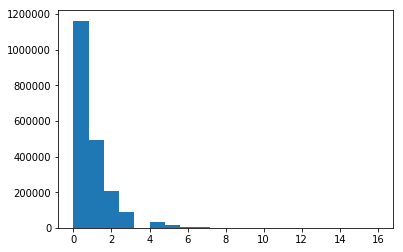

In [35]:
pyplot.hist(umi_decrease, bins=20)

In [34]:
sum(ys)

5955320

In [36]:
sum([1 for x in umi_decrease if x == 0])

1162183

In [37]:
sum([1 for x in umi_decrease if x > 0])

842191

In [40]:
sum([x for x in umi_decrease if x > 0])

1429777

In [41]:
(1429777-842191) /(842191+1162183)

0.2931518768453392

In [39]:
4 ** 10

1048576

In [47]:
different_chromosomes = {}

for i, u in enumerate(umis):
    for loc in umis[u]:
        different_chromosomes.setdefault(u, Counter())[loc[0]] += 1


In [46]:
different_chromosomes

{('CGCCAAGAGACGCACA-1', 'ATGGACACAG'): Counter({'chr10': 1, 'chr3': 1}),
 ('ATCTACTCAATGTTGC-1', 'CGAATGGAGA'): Counter({'chr10': 1, 'chr2': 1}),
 ('ATGTGTGAGATATGGT-1', 'CACACGGAGG'): Counter({'chr10': 1, 'chr2': 1}),
 ('TAGTTGGCAGCTGTGC-1',
  'TTTGGCCTAG'): Counter({'chr10': 1, 'chr7': 1, 'chrX': 1}),
 ('TGCCAAAAGCGCTTAT-1', 'CTCAGTCCAG'): Counter({'chr10': 2}),
 ('ATCTACTCAATGTTGC-1', 'ACTCAAGGGG'): Counter({'chr10': 3}),
 ('GATTCAGCAGGTGCCT-1', 'CCGAGGTGGG'): Counter({'chr10': 4}),
 ('TAGTTGGCAGCTGTGC-1', 'GGGGTGTGGT'): Counter({'chr10': 3}),
 ('CGGACGTAGCTCCTCT-1', 'GGCGTTCCTT'): Counter({'chr10': 3}),
 ('CGGACGTAGCTCCTCT-1', 'GGCGTTCCCT'): Counter({'chr10': 1}),
 ('ATCGAGTGTCTCTTTA-1', 'GTCAATTTGC'): Counter({'chr10': 1}),
 ('GATCAGTCATCACGTA-1', 'CTGCCAGGAA'): Counter({'chr10': 2}),
 ('TCTATTGTCCGATATG-1', 'ACTGCAGGAT'): Counter({'chr10': 3}),
 ('ATCGAGTGTCTCTTTA-1', 'GGCCTATGCG'): Counter({'chr10': 4}),
 ('TAAGCGTAGACACGAC-1', 'ACCTAACCAT'): Counter({'chr10': 10}),
 ('GTCCTCAGT

In [52]:
Counter(([ len(different_chromosomes[u]) for u in different_chromosomes]))

Counter({2: 113608, 3: 6450, 1: 1883961, 4: 337, 5: 18})

In [53]:
113608+6450+337+18

120413

In [54]:
120413/(120413+1883961)

0.06007511572191617

In [55]:
[u for u in different_chromosomes if len(different_chromosomes[u]) == 5]

[('GGTGAAGGTCAAGCGA-1', 'AGGAAGCGGG'),
 ('AGGTCCGCAAGGTGTG-1', 'ACAAAGCGGG'),
 ('ATCGAGTGTCTCTTTA-1', 'CTTACAGGAG'),
 ('ATCGAGTGTCTCTTTA-1', 'GTTTCAATCG'),
 ('ATCGAGTGTCTCTTTA-1', 'GCCTACGAGC'),
 ('ATGTGTGAGATATGGT-1', 'ACGCCTGAGG'),
 ('AGGTCCGCAAGGTGTG-1', 'GGTGGGTGGG'),
 ('ATCGAGTGTCTCTTTA-1', 'GCCCCAGGGA'),
 ('AGGTCCGCAAGGTGTG-1', 'TGGTACTAGT'),
 ('AGGTCCGCAAGGTGTG-1', 'ACCGGTGGGA'),
 ('GTCCTCAGTCATCGGC-1', 'ACACATTAGG'),
 ('ATCGAGTGTCTCTTTA-1', 'ACAAACGGCA'),
 ('CGAGCCACACAGCCCA-1', 'ACAATTCCCG'),
 ('GGTGAAGGTCAAGCGA-1', 'AAGGGAGGAG'),
 ('GTGCGGTTCCAGTAGT-1', 'GTCATGTCAT'),
 ('GGTGAAGGTCAAGCGA-1', 'AAGAATCTGG'),
 ('AACACGTGTAGAGTGC-1', 'ATAGAATAAG'),
 ('AGGTCCGCAAGGTGTG-1', 'AGGGTTTACA')]

In [56]:
umis[('AGGTCCGCAAGGTGTG-1', 'AGGGTTTACA')]

Counter({('chr2', 73565854, 73566005): 1,
         ('chr2', 73565878, 73566029): 1,
         ('chr2', 73565880, 73566031): 1,
         ('chr3', 94884323, 94884681): 1,
         ('chr4', 150248541, 150248692): 3,
         ('chr7', 34202343, 34202494): 1,
         ('chr8', 70508427, 70509345): 1})

In [67]:
umis[('GGTGAAGGTCAAGCGA-1', 'AAGAATCTGG')]

Counter({('chr17', 33952101, 33952444): 1,
         ('chr17', 33952101, 33952443): 1,
         ('chr17', 33952110, 33952453): 1,
         ('chr17', 33952242, 33952483): 2,
         ('chr17', 33952258, 33952499): 1,
         ('chr3', 86138034, 86138557): 1,
         ('chr5', 13605941, 13606092): 1,
         ('chr5', 13605990, 13606139): 1,
         ('chr5', 13605996, 13606147): 1,
         ('chr5', 13606005, 13606155): 1,
         ('chr7', 88530371, 88530511): 1,
         ('chr8', 107262721, 107262868): 1})

In [59]:
different_counts = Counter(([ len(different_chromosomes[u]) for u in different_chromosomes]))


<BarContainer object of 5 artists>

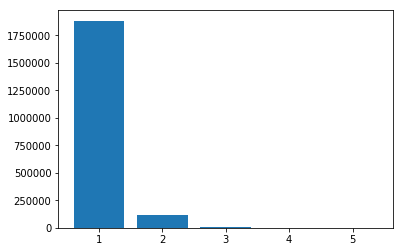

In [66]:
f = pyplot.figure()
a = f.add_subplot(1,1,1)
a.bar(range(1,6), [different_counts[x] for x in range(1,6)])

In [70]:
read.to_string()

'E00497:95:H3JGYCCXY:8:1122:12144:9941\t4\t*\t0\t0\t*\t*\t0\t0\tTCTAACTGTCCAGTCTCCACCCCTTAGTGGGGTTCATCCAAGGCCTCGTTGTGGGGCTTGGGCTTCTCTCTGTGCGTTCTTAGTTCCTGGTGGCAGCTCTTCTCAGTTTCCTCAGGTATGCGGTGGCCCTGTTCCCGCTAGTCTGTTTTGG\t-7-F<JJ-F<<<A-FF<F<FJJA7F-<J-<---AFJ-F<F<FA7FF--AFF--<777-7A7---A<AF-<F<A7--7-7F-------7-7-A<--77--A-7F<J<777-FF7A)F-A--A-7A7)-7)A))--7))--))7-----7-<-\tNH:i:0\tHI:i:0\tAS:i:98\tnM:i:10\tuT:A:1\txf:i:0\tli:i:0\tCR:Z:TTTGTCATCTTTAGTC\tCY:Z:-A-<F7F-A-AA<AJF\tCB:Z:TTTGTCATCTTTAGTC-1\tUR:Z:TTTTTGTGCG\tUY:Z:FAJJJJJJFA\tUB:Z:TTTTTGTGCG\tRG:Z:Wold10x-1-count-cells10000:0:1:H3JGYCCXY:8'

In [78]:
possorted_bam.header.keys()

odict_keys(['HD', 'SQ', 'RG', 'PG', 'CO'])

In [82]:
possorted_bam.header.get('CO')

['user command line: STAR --genomeDir /central/groups/woldlab/genomes//encode-mm10-M4-male-3.0.1/star --outSAMmultNmax -1 --runThreadN 4 --readNameSeparator space --outSAMunmapped Within KeepPairs --outSAMtype SAM --outStd SAM --outSAMorder PairedKeepInputOrder --outSAMattrRGline ID:Wold10x-1-count-cells10000:0:1:H3JGYCCXY:8 SM:Wold10x-1-count-cells10000 LB:0.1 PU:Wold10x-1-count-cells10000:0:1:H3JGYCCXY:8 PL:ILLUMINA --readFilesIn /dev/fd/63',
 '10x_bam_to_fastq:I1(BC:QT)',
 '10x_bam_to_fastq:R1(CR:CY,UR:UY)',
 '10x_bam_to_fastq:R2(SEQ:QUAL)',
 'library_info:{"library_id":"0","library_type":"Gene Expression","gem_group":1}',
 'user command line: STAR --genomeDir /central/groups/woldlab/genomes//encode-mm10-M4-male-3.0.1/star --outSAMmultNmax -1 --runThreadN 4 --readNameSeparator space --outSAMunmapped Within KeepPairs --outSAMtype SAM --outStd SAM --outSAMorder PairedKeepInputOrder --outSAMattrRGline ID:Wold10x-1-count-cells10000:0:1:H3JGYCCXY:8 SM:Wold10x-1-count-cells10000 LB:0.1 PU

In [86]:
total = 0
for stat in possorted_bam.get_index_statistics():
    total += stat.total
print(total)

465261597


In [88]:
465261597 * (len(cb) + len(ub) + len('chr10') + 4)

17214679089

In [101]:
def plot_mapqs(filename):
    bam = pysam.AlignmentFile(filename, 'rb')
    mapq = Counter()
    for read in bam:
        mapq[read.mapq] += 1
    f = pyplot.figure(figsize=(8,6))
    a = f.add_subplot(1,1,1)
    a.bar(mapq.keys(), mapq.values())
    return mapq

Counter({0: 3855479, 1: 1317434, 255: 22627532, 3: 2480886})

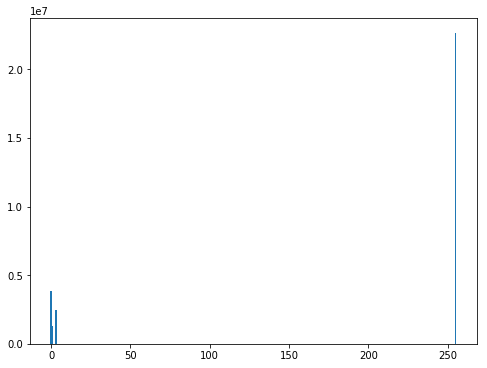

In [102]:
plot_mapqs('c12_mus4_cb_ub_chr_start/c12_mus4_cb_ub_chr_start-mm10-M4-male_genome.bam')

Counter({255: 29873564, 0: 5212898, 3: 3273528, 1: 1717915})

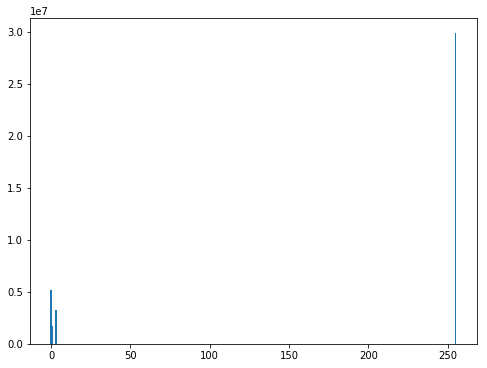

In [104]:
plot_mapqs('c12_mus4/c12-mus4-mm10-M4-male_genome.bam')